<a href="https://colab.research.google.com/github/sokkarbishoy/DATA620/blob/main/DATA620_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Cell 1 – Download the dataset (your working link)
!wget -q https://raw.githubusercontent.com/gustika17/healthcare-dataset-stroke-data.csv/refs/heads/main/healthcare-dataset-stroke-data.csv -O stroke_data.csv

# Cell 2 – Load and explore
import pandas as pd
df = pd.read_csv('stroke_data.csv')
print("Shape:", df.shape)          # (5110, 12)
print("Columns:", df.columns.tolist())
df.head()

Shape: (5110, 12)
Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [13]:
# Cell 3 – Quick sentiment on realistic “care notes” generated from the data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def make_care_note(row):
    issues = []
    if row['hypertension']: issues.append('hypertension')
    if row['heart_disease']: issues.append('heart disease')
    if row['stroke']: issues.append('previous stroke')
    smoking = '' if row['smoking_status'] in ['Unknown','never smoked'] else f", smokes {row['smoking_status']}"
    note = f"Patient age {int(row['age'])}, {row['gender']}, {row['work_type']} job in {row['Residence_type']} area. Conditions: {', '.join(issues) or 'none reported'}{smoking}. BMI {row['bmi']}, glucose {row['avg_glucose_level']:.0f}."
    return note

df['care_note'] = df.apply(make_care_note, axis=1)
sample_notes = df['care_note'].sample(500, random_state=42)

sentiments = sample_notes.apply(lambda x: analyzer.polarity_scores(x)['compound'])
print(f"Average sentiment in care notes: {sentiments.mean():.3f}")
print(f"% negative notes: {(sentiments < -0.05).mean()*100:.1f}%")
print(f"% positive notes: {(sentiments > 0.05).mean()*100:.1f}%")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Average sentiment in care notes: 0.042
% negative notes: 0.0%
% positive notes: 6.6%


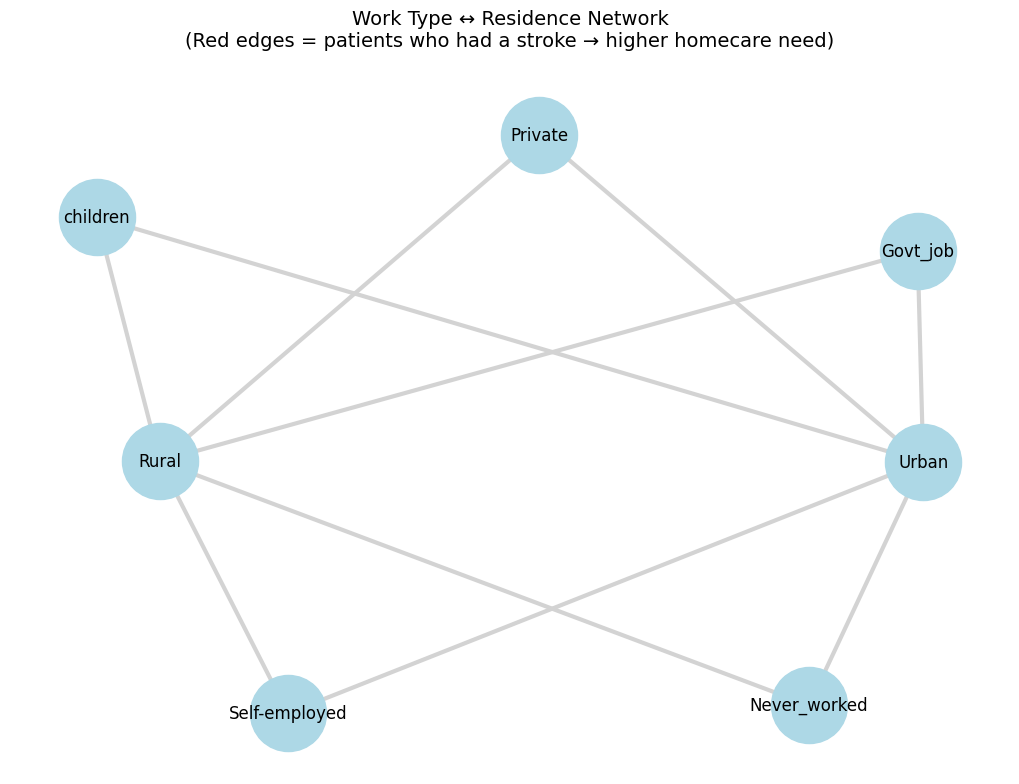

In [14]:
# Cell 4 – Network: Work type ↔ Residence type (edges colored by stroke cases)
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['work_type'], row['Residence_type'],
               stroke=row['stroke'])  # edge attribute

pos = nx.spring_layout(G, k=3, seed=42)
edge_colors = ['red' if d['stroke'] else 'lightgray' for u,v,d in G.edges(data=True)]

plt.figure(figsize=(10,7))
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=12, edge_color=edge_colors, width=3)
plt.title("Work Type ↔ Residence Network\n(Red edges = patients who had a stroke → higher homecare need)",
          fontsize=14, pad=20)
plt.show()

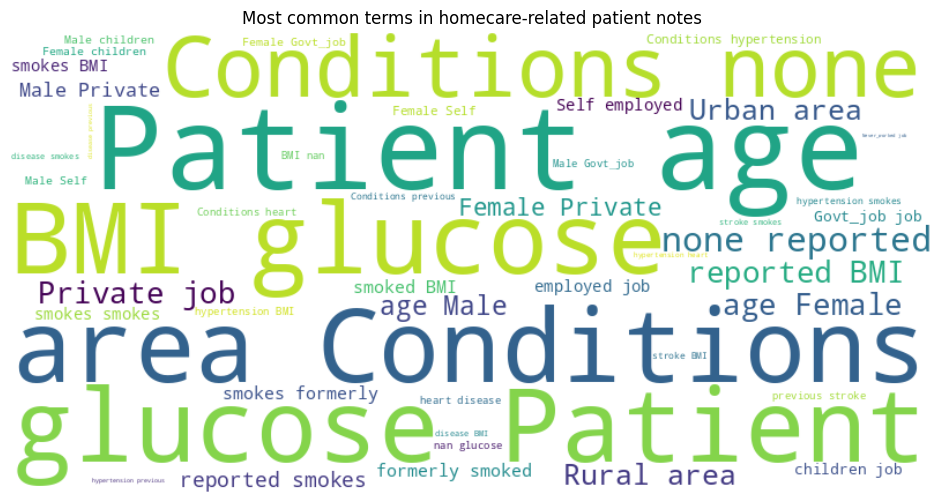

In [15]:
# Cell 5 – Optional: Quick word cloud of the care notes
!pip install wordcloud -q
from wordcloud import WordCloud

text = " ".join(df['care_note'].tolist())
wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most common terms in homecare-related patient notes")
plt.show()